数据集：https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

教程1：https://mp.weixin.qq.com/s/7HvuEGmO4Nm1l2-dQTdGUA

教程2：https://github.com/oserttas-math/MalariaDayApr25/blob/master/notebooks/Version1.0.ipynb

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import cv2
import os
import random
import keras

In [4]:
root = './Data/cell_images/'
pa = '/Parasitized/'
un = '/Uninfected/'

In [6]:
Parasitized = os.listdir(root+pa)
Uninfected = os.listdir(root+un)

# 显示图像

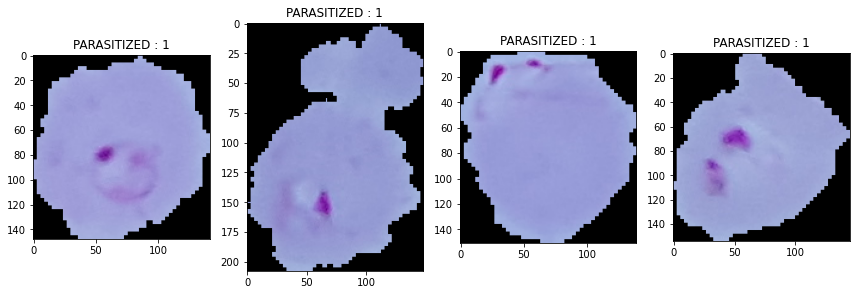

In [9]:
plt.figure(figsize=(12,24))
for i in range(4):
    plt.subplot(1,4,i+1)
    img = cv2.imread(root+pa+Parasitized[i])
    plt.imshow(img)
    plt.title('PARASITIZED : 1')
    plt.tight_layout()
plt.show()

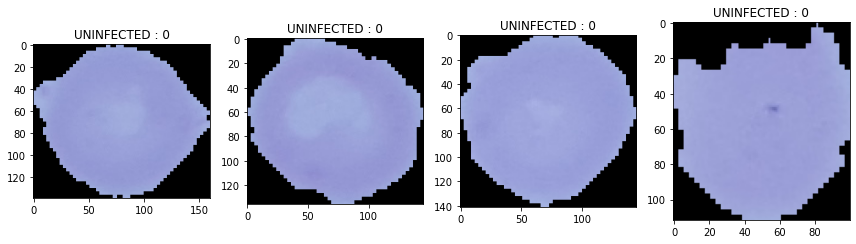

In [10]:
plt.figure(figsize=(12,24))
for i in range(4):
    plt.subplot(1,4,i+1)
    img = cv2.imread(root+un+Uninfected[i])
    plt.imshow(img)
    plt.title('UNINFECTED : 0')
    plt.tight_layout()
plt.show()

# 长宽均值

D:\A\Python\Software\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


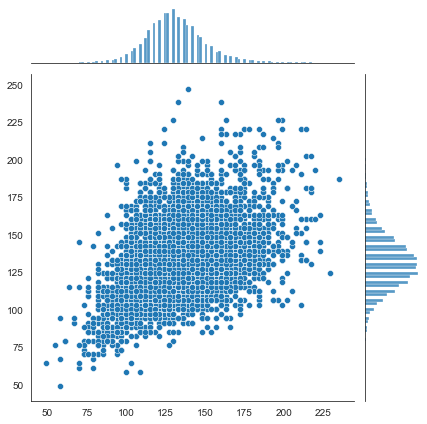

In [59]:
dim1,dim2 = [],[]

for img_file in os.listdir(root+un):
    img = plt.imread(root+un+img_file)
    d1, d2, colors = img.shape
    dim1.append(d1)
    dim2.append(d2)
    
sns.jointplot(dim1, dim2)

In [60]:
print(np.mean(dim1))
print(np.mean(dim2))

131.58001306335728
131.3424776834313


# 将图像和标签分配到变量中

In [11]:
from tensorflow.keras.preprocessing.image import img_to_array

data = []
labels = []
 
for img in Parasitized:
    try:
        img_read = plt.imread(root+pa+img)
        img_resize = cv2.resize(img_read,(100,100))
        img_array = img_to_array(img_resize)#将图片转换为数组格式
        data.append(img_array)
        labels.append(1)
    except:
        None

for img in Uninfected:
    try:
        img_read = plt.imread(root+un+img)
        img_resize = cv2.resize(img_read,(100,100))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        None

# 预处理数据

In [15]:
from sklearn.utils import shuffle

# 将数据和标签变量转换为Numpy格式
image_data = np.array(data)
labels = np.array(labels)

# 将被随机数据重新分配到它们的原始变量中
idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

# 拆分训练集、测试集和验证集

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 将数据转换为32位数据以保存
def prep_dataset(X,y):
    X_prep = X.astype('float32')/255
    y_prep = to_categorical(np.array(y))
    return (X_prep,y_prep)

# stratify按照labels比例划分数据集
X_tr, X_ts, Y_tr, Y_ts = train_test_split(image_data,labels,test_size=0.15,shuffle=True,stratify=labels,random_state=42)
X_ts, X_val, Y_ts, Y_val = train_test_split(X_ts,Y_ts,test_size=0.5,stratify=Y_ts,random_state=42)

X_tr, Y_tr = prep_dataset(X_tr, Y_tr)
X_val, Y_val = prep_dataset(X_val, Y_val)
X_ts, Y_ts = prep_dataset(X_ts, Y_ts)

# 构建模型

In [19]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

model = models.Sequential()

#Input + Conv 1 + ReLU + Max Pooling
model.add(layers.Conv2D(32,(5,5),activation='relu',padding='same',input_shape=X_tr.shape[1:]))
model.add(layers.MaxPool2D(strides=4))
model.add(layers.BatchNormalization())

# Conv 2 + ReLU + Max Pooling
model.add(layers.Conv2D(64,(5,5),padding='same',activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

# Conv 3 + ReLU + Max Pooling
model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

# Conv 4 + ReLU + Max Pooling
model.add(layers.Conv2D(256,(3,3),dilation_rate=(2,2),padding='same',activation='relu'))
model.add(layers.Conv2D(256,(3,3),activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

# Fully Connected + ReLU
model.add(layers.Flatten())
model.add(layers.Dense(300,activation='relu'))
model.add(layers.Dense(100,activation='relu'))

#Output
model.add(layers.Dense(2,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 100, 100, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)      

In [21]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# 早停法旨在解决epoch数量需要手动设置的问题
# 它也可以被视为一种能够避免网络发生过拟合的正则化方法（与L1/L2权重衰减和丢弃法类似）
# patience容忍3个epoch内都没有提升
es = EarlyStopping(monitor='val_acc',mode='max',patience=3,verbose=1)
history = model.fit(X_tr,Y_tr,
                   epochs=20,
                   batch_size=50,
                   validation_data=(X_val,Y_val),
                   callbacks=[es])

Train on 23424 samples, validate on 2067 samples
Epoch 1/20
23424/23424 [==============================] - 272s 12ms/sample - loss: 0.2773 - acc: 0.8854 - val_loss: 1.3771 - val_acc: 0.5002
Epoch 2/20
23424/23424 [==============================] - 277s 12ms/sample - loss: 0.1333 - acc: 0.9568 - val_loss: 0.1784 - val_acc: 0.9598
Epoch 3/20
23424/23424 [==============================] - 277s 12ms/sample - loss: 0.1214 - acc: 0.9585 - val_loss: 0.1358 - val_acc: 0.9545
Epoch 4/20
23424/23424 [==============================] - 276s 12ms/sample - loss: 0.1108 - acc: 0.9616 - val_loss: 0.1407 - val_acc: 0.9647
Epoch 5/20
23424/23424 [==============================] - 276s 12ms/sample - loss: 0.1027 - acc: 0.9647 - val_loss: 0.1183 - val_acc: 0.9627
Epoch 6/20
23424/23424 [==============================] - 276s 12ms/sample - loss: 0.0945 - acc: 0.9669 - val_loss: 0.1231 - val_acc: 0.9642
Epoch 7/20
23424/23424 [==============================] - 276s 12ms/sample - loss: 0.0883 - acc: 0.9689 -

# 评估

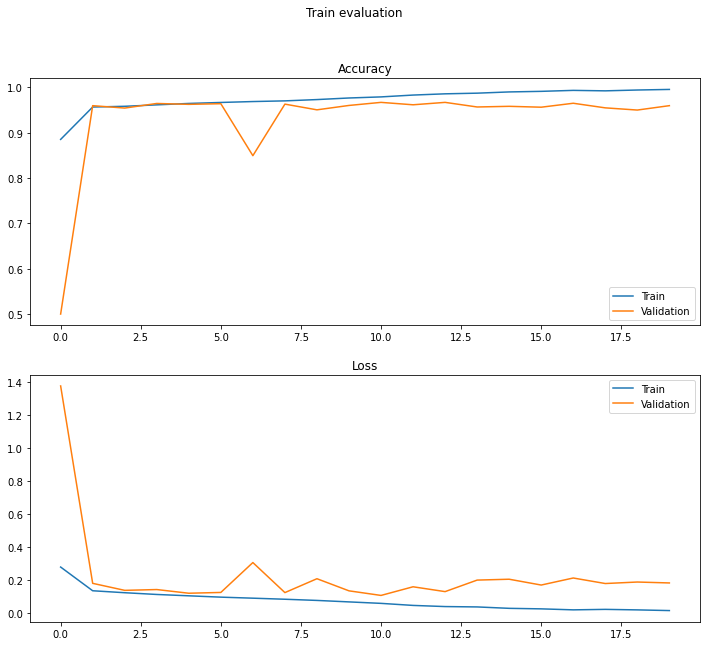

In [33]:
import seaborn as sns

fig, ax = plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')

sns.lineplot(ax=ax[0],x=np.arange(0,len(history.history['acc'])),y=history.history['acc'])
sns.lineplot(ax=ax[0],x=np.arange(0,len(history.history['acc'])),y=history.history['val_acc'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax=ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax=ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')

plt.show()

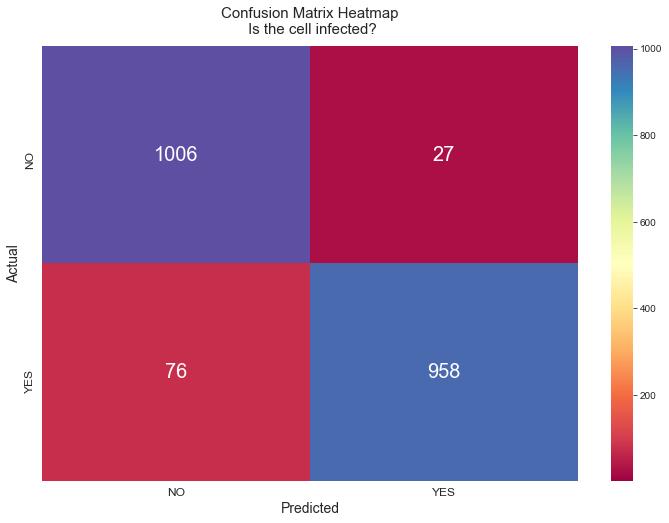

-Acuracy achieved: 95.02%
-Accuracy by model was: 99.56%
-Accuracy by validation was: 95.98%


In [53]:
# 构建一个混淆矩阵
from sklearn.metrics import confusion_matrix, accuracy_score

Y_pred = model.predict(X_ts)

Y_pred = np.argmax(Y_pred, axis=1)
Y_ts_r = np.argmax(Y_ts, axis=1)
conf_mat = confusion_matrix(Y_ts_r,Y_pred)

sns.set_style(style='white')
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":20},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap\n Is the cell infected?', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(['NO','YES'], fontdict={'fontsize':12})
heatmap.set_yticklabels(['NO','YES'], fontdict={'fontsize':12})
plt.show()

print('-Acuracy achieved: {:.2f}%\n-Accuracy by model was: {:.2f}%\n-Accuracy by validation was: {:.2f}%'.
      format(accuracy_score(Y_ts_r,Y_pred)*100,(history.history['acc'][-1])*100,(history.history['val_acc'][-1])*100))

# 错误样本

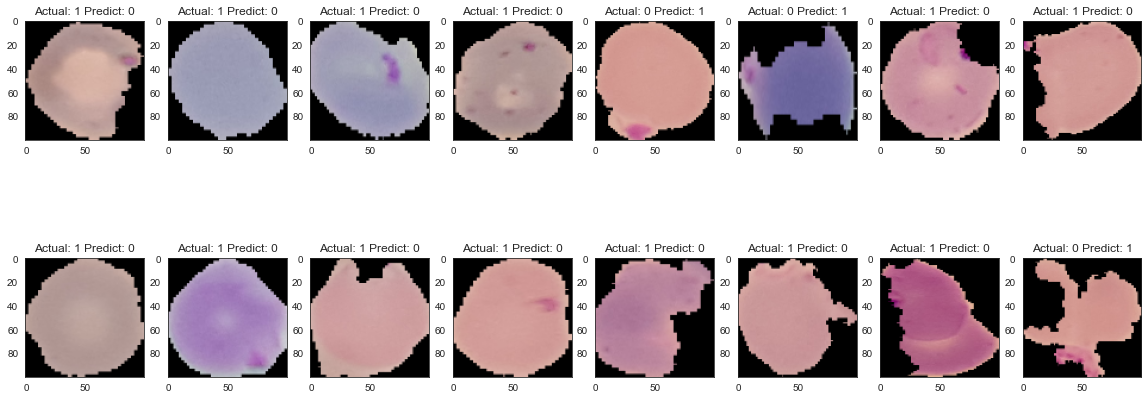

In [52]:
index=0
index_errors= []

for label, predict in zip(Y_ts_r,Y_pred):
    if label != predict:
        index_errors.append(index)
    index +=1

plt.figure(figsize=(20,8))

for i,img_index in zip(range(1,17),random.sample(index_errors,k=16)):
    plt.subplot(2,8,i)
    plt.imshow(np.reshape(255*X_ts[img_index], (100,100,3)))
    plt.title('Actual: '+str(Y_ts_r[img_index])+' Predict: '+str(Y_pred[img_index]))
plt.show()